Практическая работа № 6

Выполнил студент группы ББМО-02-23: Костомахин А.А.

Цель работы:

Загрузить несколько моделей, обученных на датасете MNIST.
Изучить теоретические основы атаки по переносу.
Реализовать атаку FGSM на одну модель и проверить, как противоречивые примеры влияют на другую модель.
Оценить точность обеих моделей на противоречивых примерах и проанализировать переносимость атак.

In [1]:
import tensorflow as tf
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.utils import to_categorical
# Загрузка датасета MNIST
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()
# Нормализация данных
train_images = train_images / 255.0
test_images = test_images / 255.0
# Преобразование меток в one-hot encoding
train_labels = to_categorical(train_labels)
test_labels = to_categorical(test_labels)
# Создание простой полносвязной модели
model1 = Sequential([
 Flatten(input_shape=(28, 28)),
 Dense(128, activation='relu'),
 Dense(10, activation='softmax')])
# Компиляция модели
model1.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
# Обучение модели
model1.fit(train_images, train_labels, epochs=5)
# Проверка точности модели на обычных данных
test_loss, test_acc = model1.evaluate(test_images, test_labels)
print(f'Test accuracy on clean images: {test_acc}')
model1.save('mnist_model1.h5') # сохранение модели
# Создание модели свёрточной нейронной сети
model2 = Sequential([
 Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)),
 MaxPooling2D((2, 2)),
 Flatten(),
 Dense(128, activation='relu'),
 Dense(10, activation='softmax')])
# Компиляция модели
model2.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
# Обучение модели
model2.fit(train_images, train_labels, epochs=5)
# Проверка точности модели на обычных данных
test_loss, test_acc = model2.evaluate(test_images, test_labels)
print(f'Test accuracy on clean images: {test_acc}')
model1.save('mnist_model2.h5') # сохранение модели

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - accuracy: 0.8781 - loss: 0.4354
Epoch 2/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - accuracy: 0.9654 - loss: 0.1208
Epoch 3/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.9763 - loss: 0.0801
Epoch 4/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step - accuracy: 0.9831 - loss: 0.0575
Epoch 5/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9861 - loss: 0.0438
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9739 - loss: 0.0907


Test accuracy on clean images: 0.9775999784469604


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - accuracy: 0.9107 - loss: 0.2992
Epoch 2/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - accuracy: 0.9843 - loss: 0.0511
Epoch 3/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9907 - loss: 0.0302
Epoch 4/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9939 - loss: 0.0201
Epoch 5/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9957 - loss: 0.0131
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9830 - loss: 0.0515


Test accuracy on clean images: 0.9871000051498413


In [5]:
import numpy as np
# Функция для реализации FGSM атаки
def fgsm_attack(image, epsilon, gradient):
  # Применение знака градиента к изображению
  perturbed_image = image + epsilon * np.sign(gradient)
  # Обрезка значений, чтобы они оставались в пределах [0,1]
  perturbed_image = np.clip(perturbed_image, 0, 1)
  return perturbed_image
# Вычисление градиента
def generate_adversarial_example(model, images, labels, epsilon):
    adversarial_images = []
    # Превращаем изображение в формат, подходящий для модели
    for i in range(len(images)):
      image = tf.convert_to_tensor(images[i].reshape((1, 28, 28, 1)))
      label = labels[i]
      # Если label — это one-hot вектор, преобразуем его в индекс
      if len(label.shape) > 1 and label.shape[1] > 1:
          label = np.argmax(label),
      label = tf.convert_to_tensor(label)
      with tf.GradientTape() as tape:
          tape.watch(image)
          prediction = model(image)
          loss = tf.keras.losses.categorical_crossentropy(label[None], prediction)
      gradient = tape.gradient(loss, image)
      # Применяем FGSM
      adversarial_image = fgsm_attack(image.numpy(), epsilon, gradient.numpy())
      adversarial_images.append(np.reshape(adversarial_image, (28, 28, 1)))
    return np.array(adversarial_images)
epsilon = 0.15 # Величина шума
# Создаём противоречивые изображения для простой полносвязной модели
adversarial_example = generate_adversarial_example(model1, test_images, test_labels, epsilon)

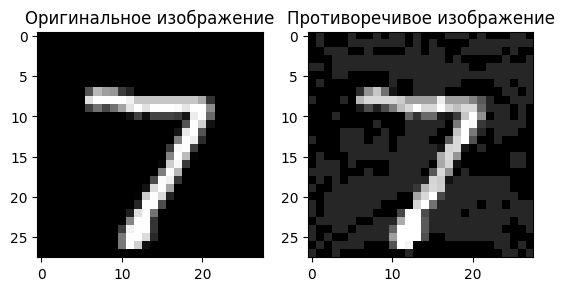

In [6]:
# Пример противоречивого изображения
import matplotlib.pyplot as plt
plt.figure()
plt.subplot(1, 2, 1)
plt.title("Оригинальное изображение")
plt.imshow(test_images[0], cmap="gray")
plt.subplot(1, 2, 2)
plt.title("Противоречивое изображение")
plt.imshow(adversarial_example[0].reshape(28, 28), cmap="gray")
plt.show()


In [7]:
# Оценка полносвязной модели на противоречивых примерах
adversarial_loss1, adversarial_acc1 = model1.evaluate(adversarial_example.reshape(10000, 28, 28),
test_labels)
# Оценка свёрточной модели на противоречивых примерах
adversarial_loss2, adversarial_acc2 = model2.evaluate(adversarial_example.reshape(10000, 28, 28),
test_labels)
print(f'Точность полносвязной модели: {adversarial_acc1}')
print(f'Точность свёрточной модели: {adversarial_acc2}')

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.0136 - loss: 12.0838
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9308 - loss: 0.2310
Точность полносвязной модели: 0.02280000038444996
Точность свёрточной модели: 0.9394000172615051


In [8]:
# Создаём противоречивые изображения для свёрточной модели
adversarial_example = generate_adversarial_example(model2, test_images, test_labels, epsilon)

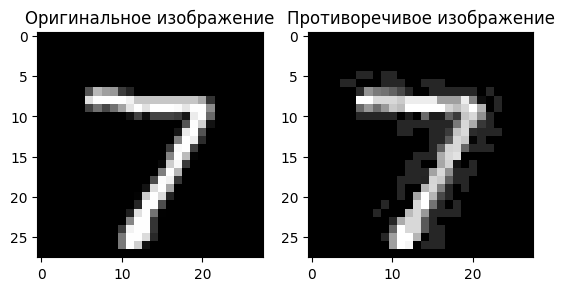

In [9]:
# Пример противоречивого изображения
plt.figure()
plt.subplot(1, 2, 1)
plt.title("Оригинальное изображение")
plt.imshow(test_images[0], cmap="gray")
plt.subplot(1, 2, 2)
plt.title("Противоречивое изображение")
plt.imshow(adversarial_example[0].reshape(28, 28), cmap="gray")
plt.show()

In [10]:
# Оценка полносвязной модели на противоречивых примерах
adversarial_loss1, adversarial_acc1 = model1.evaluate(adversarial_example.reshape(10000, 28, 28),
test_labels)
# Оценка свёрточной модели на противоречивых примерах
adversarial_loss2, adversarial_acc2 = model2.evaluate(adversarial_example.reshape(10000, 28, 28),
test_labels)
print(f'Точность полносвязной модели: {adversarial_acc1}')
print(f'Точность свёрточной модели: {adversarial_acc2}')

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9442 - loss: 0.1887
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.3829 - loss: 2.8422
Точность полносвязной модели: 0.9514999985694885
Точность свёрточной модели: 0.3978999853134155


Вывод:

В ходе работы было исследовано воздействие атаки по переносу, при которой противоречивые примеры, созданные для одной модели, использовались для атаки на другую. Метод FGSM позволил эффективно генерировать такие примеры, искажающие предсказания.

Результаты эксперимента показали, что точность модели 1 резко упала, что свидетельствует о высокой уязвимости к атакам. Однако модель 2, протестированная на тех же примерах, сохранила точность на уровне 95.1%, продемонстрировав значительную устойчивость к переносу атак.

Когда противоречивые примеры были сгенерированы для модели 2 и использованы против модели 1, точность последней снизилась до 94.42%, что меньше, чем в первом случае, и подтверждает её меньшую восприимчивость к атакам, созданным для другой модели.

Эти результаты показывают, что атака по переносу с использованием FGSM может существенно снизить точность, особенно если примеры созданы для целевой модели. В то же время, более устойчивые модели сохраняют точность при воздействии атак, перенесённых с других моделей, подчёркивая важность разработки методов защиты от таких атак.